In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'lines.markersize': 10})

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import ttest_1samp
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.stats import iqr

from copy import deepcopy

import divebomb

import time
import pickle

import importlib

np.random.seed(0)

import Preprocessor
import Parameters
import HHMM
import Visualisor

In [2]:
print(expit([3.3403, 1.5665, 0.4267]))

def eta_2_ptm(eta):
    ptm = np.exp(eta)
    return (ptm.T/np.sum(ptm,1)).T

eta_2_ptm(np.array([[  0.    ,  -2.0691, -13.2605],
         [ -1.6902,   0.    ,  -3.1311],
         [-16.9396,  -1.2303,   0.    ]]))

[0.96578576 0.82728408 0.60508538]


array([[8.87862014e-01, 1.12136440e-01, 1.54661956e-06],
       [1.50211513e-01, 8.14231226e-01, 3.55572611e-02],
       [3.40324954e-08, 2.26128915e-01, 7.73871051e-01]])

In [3]:
FoVeDBA_mu = np.array([[34.98],[505.79],[9769.98]])
FoVeDBA_mu.flatten()

array([  34.98,  505.79, 9769.98])

# Load in the HMMs

In [4]:
model = 'hhmm_FV'
titl = 'CarHHMM-DFT'

#model = 'hhmm_FV_uncorr'
#titl = 'HHMM-DFT'

#model = 'hhmm_V'
#titl = 'CarHHMM'

#model = 'hmm_FV'
#titl = 'CarHMM-DFT'


rngs = {'hhmm_FV': range(1501,2001),
        'hhmm_FV_uncorr': range(501,1001),
        'hhmm_V': range(1001,1501),
        'hmm_FV': range(1,501)}

#date = '07_22_20'
#date = '08_20_20'
#date = '09_08_20'
#date = 'new_sim'
date = '07_06_2021'

hhmms = []
for dataset_num in rngs[model]:
    try:
        file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
        with open(file, 'rb') as f:
            hhmm = pickle.load(f)
            A = hhmm.SEs
            if A is None:
                print(file)
        hhmms.append(hhmm)
    except:
        print('../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num))

../../Params/sims/07_06_2021/hhmm_FV_0_1508
../../Params/sims/07_06_2021/hhmm_FV_0_1599
../../Params/sims/07_06_2021/hhmm_FV_0_1668
../../Params/sims/07_06_2021/hhmm_FV_0_1734
../../Params/sims/07_06_2021/hhmm_FV_0_1863
../../Params/sims/07_06_2021/hhmm_FV_0_1869
../../Params/sims/07_06_2021/hhmm_FV_0_1943


# Plot Empirical distribtuion
 - Compare with Fischer SEs

In [5]:
def make_2d_kde_theta(feature,theta0,hhmms,dive_type,N,include_corr=False,feature_name=''):
    
    # get mu and sigma and corr
    if dive_type == -1:
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[0][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    else:
        mus = np.array([hhmm.theta[1][dive_type][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][dive_type][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[1][dive_type][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    # get a 2-D histogram of these guys
    for i in range(N):

        xlim = [np.mean(mus[:,i])-3*np.std(mus[:,i]),np.mean(mus[:,i])+3*np.std(mus[:,i])]
        ylim = [np.mean(sigs[:,i])-3*np.std(sigs[:,i]),np.mean(sigs[:,i])+3*np.std(sigs[:,i])]
        zlim = [np.mean(corrs[:,i])-3*np.std(corrs[:,i]),np.mean(corrs[:,i])+3*np.std(corrs[:,i])]
        
        if theta0:
            xlim[0] = min(xlim[0],theta0['mu'][i])
            xlim[1] = max(xlim[1],theta0['mu'][i])
            ylim[0] = min(ylim[0],theta0['sig'][i])
            ylim[1] = max(ylim[1],theta0['sig'][i])
            zlim[0] = min(zlim[0],theta0['corr'][i])
            zlim[1] = max(zlim[1],theta0['corr'][i])
        
        if include_corr:
            fig, axs = plt.subplots(2,2,figsize = (6,6))

            plt.subplot(2,2,1)
            kernel = gaussian_kde([mus[:,i],corrs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,zlim[0]:zlim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + zlim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['corr'][i],'r*')
            c = plt.colorbar()
            c.set_label('Density')
            plt.xticks([])
            if dive_type == -1:
                plt.ylabel(r'$\hat \phi_%s^{(%d)}$' % (feature_name,i+1))
            else:
                plt.ylabel(r'$\hat \phi_%s^{*(\cdot,%d)}$' % (feature_name,i+1))

            fig.delaxes(axs[0,1])

            plt.subplot(2,2,3)
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            if dive_type == -1:
                plt.ylabel(r'$\hat \mu^{(%d)}$' % (i+1))
                plt.ylabel(r'$\hat \sigma^{(%d)}$' % (i+1))
            else:
                plt.xlabel(r'$\hat \mu_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
                plt.ylabel(r'$\hat \sigma_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
            
            plt.subplot(2,2,4)
            kernel = gaussian_kde([corrs[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[zlim[0]:zlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = zlim + ylim, aspect='auto')
            plt.plot(theta0['corr'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            c.set_label('Density')
            if dive_type == -1:
                plt.xlabel(r'$\hat \phi_%s^{(%d)}$' % (feature_name,i+1))
            else:
                plt.xlabel(r'$\hat \phi_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
            plt.yticks([])
            fig.suptitle(titl)
            

            
        else:
            
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.figure(figsize = (4,3))
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            if theta0:
                plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            c.set_label('Density')
            plt.xlabel(r'$\hat \mu$')
            plt.ylabel(r'$\hat \sigma$')
            plt.title(titl)
            if dive_type == -1:
                plt.xlabel(r'$\hat \mu^{(%d)}$' % (i+1))
                plt.ylabel(r'$\hat \sigma^{(%d)}$' % (i+1))
            else:
                plt.xlabel(r'$\hat \mu_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
                plt.ylabel(r'$\hat \sigma_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('../Plots/%s_MLE_density_%s_%d_%d.png'%(model,feature,dive_type,i),dpi=300)
        plt.show()
        
    print(r'$\hat \mu$ sample mean:', np.mean(mus,0))
    if theta0:
        print('Bias:', np.mean(mus,0) - np.array(theta0['mu']))
    print('Empirical Standard Error:', np.std(mus,0))
    print('Fischer Standard Error:',np.nanmedian(mus_SE,0))
    print('pm:',np.std(mus_SE,0))
    print('')

    print(r'$\sigma$ sample mean:', np.mean(sigs,0))
    if theta0:
        print('Bias:', np.mean(sigs,0) - np.array(theta0['sig']))
    print('Empirical Standard Error:', np.std(sigs,0))
    print('Fischer Standard Error:',np.nanmedian(sigs_SE,0))
    print('pm:',np.std(sigs_SE,0))
    print('')

    if include_corr:
        print(r'$\rho$ sample mean:', np.mean(corrs,0))
        if theta0:
            print('Bias:', np.mean(corrs,0) - np.array(theta0['corr']))
        print('Empirical Standard Error:', np.std(corrs,0))
        print('Fischer Standard Error:',np.nanmedian(corrs_SE,0))
        print('pm:',np.std(corrs_SE,0))
        print('')
        
    return


def make_2d_kde_gamma(G0,hhmms,dive_type,rownum):
    
    Gs = []
    SEs = []
    for hhmm in hhmms:
        if dive_type == -1:
            ptm = HHMM.eta_2_ptm(hhmm.eta[0])
            try:
                SE = hhmm.SEs['Gamma_coarse']
            except:
                print(hhmm.SEs)
            Gs.append(np.array([ptm[0,1],ptm[1,0]]))
            SEs.append(np.array([SE[0,1],SE[1,0]]))
        else:
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][dive_type])
            SE = hhmm.SEs['Gamma_fine'][dive_type]
            colnums = [0,1,2]
            colnums.remove(rownum)
            Gs.append(np.array([ptm[rownum,colnums[0]],
                                ptm[rownum,colnums[1]]]))
            SEs.append(np.array([SE[rownum,colnums[0]],
                                 SE[rownum,colnums[1]]]))

    Gs = np.array(Gs)
    
    xlim = [np.mean(Gs[:,0])-3*np.std(Gs[:,0]),np.mean(Gs[:,0])+3*np.std(Gs[:,0])]
    ylim = [np.mean(Gs[:,1])-3*np.std(Gs[:,1]),np.mean(Gs[:,1])+3*np.std(Gs[:,1])]
    
    if G0:
        xlim[0] = max(min(xlim[0],G0[0]),0.0)
        xlim[1] = min(max(xlim[1],G0[0]),1.0)
        ylim[0] = max(min(ylim[0],G0[1]),0.0)
        ylim[1] = min(max(ylim[1],G0[1]),1.0)
    
    print(Gs)
    
    kernel = gaussian_kde([Gs[:,0],Gs[:,1]])
    Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
    positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
    Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
    plt.figure(figsize=(4,3))
    plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
    if G0:
        plt.plot(G0[0],G0[1],'r*')
    c = plt.colorbar()
    c.set_label('Density')
    plt.xlabel('$\Gamma_{12}$')
    plt.ylabel('$\Gamma_{21}$')
    if dive_type == -1:
        plt.title(titl)
        plt.xlabel('$\hat \Gamma_{12}$')
        plt.ylabel('$\hat \Gamma_{21}$')
    else:
        plt.title(titl)
        plt.xlabel('$\hat \Gamma^{*(%d)}_{%d,%d}$' % (dive_type+1,rownum+1,colnums[0]+1))
        plt.ylabel('$\hat \Gamma^{*(%d)}_{%d,%d}$' % (dive_type+1,rownum+1,colnums[1]+1))
        
    plt.tight_layout()
    plt.savefig('../Plots/%s_Gamma_density_%d_row_%d.png'%(model,dive_type,rownum),dpi=300)
    plt.show()

    print('Sample Mean:', np.mean(Gs,0))
    if G0:
        print('Bias:', np.mean(Gs,0) - G0)
    print('Empirical Standard Error: \n', np.std(Gs,0))
    print('Fischer Standard Error: \n', np.nanmedian(SEs,0))
    print('pm:', np.std(SEs,0))
    
    return

# Consider $\hat \Gamma$

In [6]:
for i in range(500):
    try:
        if hhmms[i].SEs is None:
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[0])):
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[1][0])):
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[1][1])):
            hhmms.pop(i)
    except IndexError:
        break

[[0.12881107 0.91573932]
 [0.15108691 0.92898708]
 [0.14802261 0.83764593]
 [0.20855553 0.80799814]
 [0.03058771 0.99996811]
 [0.13422915 0.99999926]
 [0.25312574 0.74323963]
 [0.10268561 0.9999892 ]
 [0.34077337 0.82798484]
 [0.18220386 0.9999996 ]
 [0.18966916 0.99999845]
 [0.14660403 0.99999894]
 [0.07448747 0.99999841]
 [0.26470657 0.99999976]
 [0.11700644 0.61053381]
 [0.18487992 0.99998681]
 [0.1585161  0.85053679]
 [0.07538247 0.99999948]
 [0.21029681 0.73220432]
 [0.18090579 0.99999181]
 [0.0953196  0.76416611]
 [0.13247763 0.88383128]
 [0.13993822 0.75366445]
 [0.22392165 0.87211245]
 [0.15946248 0.99999475]
 [0.19655761 0.93859223]
 [0.10295797 0.99998375]
 [0.14102353 0.99999996]
 [0.23180949 0.90365562]
 [0.12633307 0.89429395]
 [0.07630784 0.99999978]
 [0.19436437 0.69482719]
 [0.07236378 0.99998064]
 [0.07422238 0.73742045]
 [0.12388483 0.76479137]
 [0.17662771 0.99999442]
 [0.18623242 0.93690221]
 [0.11144189 0.99999094]
 [0.14716862 0.92514876]
 [0.09852026 0.99999984]


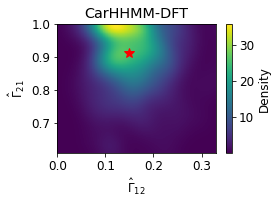

Sample Mean: [0.15541568 0.91139552]
Bias: [0.00541568 0.00139552]
Empirical Standard Error: 
 [0.05804782 0.10051816]
Fischer Standard Error: 
 [0.04075532 0.08690751]
pm: [0.01048546        nan]
[[2.56739739e-01 1.08116798e-10]
 [2.51513456e-01 1.08877028e-10]
 [2.86188899e-01 1.03833037e-10]
 [2.43020241e-01 1.10112476e-10]
 [2.30922994e-01 1.11872177e-10]
 [2.84701533e-01 1.04049394e-10]
 [3.87061062e-01 8.91598795e-11]
 [2.40294174e-01 1.10509018e-10]
 [2.53512545e-01 1.08586235e-10]
 [1.90877509e-01 1.17697309e-10]
 [3.13914088e-01 9.98000509e-11]
 [2.30979710e-01 1.11863926e-10]
 [2.73073000e-01 1.05740914e-10]
 [3.09717263e-01 1.00410533e-10]
 [3.14556417e-01 9.97066158e-11]
 [2.36611227e-01 1.11044750e-10]
 [2.58602680e-01 1.07845809e-10]
 [2.96015188e-01 1.02403677e-10]
 [2.18640068e-01 1.13658887e-10]
 [3.12184301e-01 1.00051671e-10]
 [2.51263818e-01 1.08913341e-10]
 [2.21271344e-01 1.13276134e-10]
 [2.98070686e-01 1.02104678e-10]
 [2.32476053e-01 1.11646264e-10]
 [2.6337641

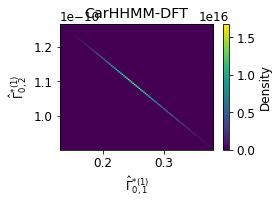

Sample Mean: [2.55002711e-01 1.08369502e-10]
Empirical Standard Error: 
 [4.18302085e-02 6.08478088e-12]
Fischer Standard Error: 
 [3.12966007e-02 5.11486912e-08]
pm: [0.00654085        nan]
[[0.09483993 0.0687252 ]
 [0.07331586 0.04434823]
 [0.09433359 0.05510761]
 [0.11437212 0.0604688 ]
 [0.07225529 0.05632284]
 [0.089053   0.04191235]
 [0.10599893 0.05463959]
 [0.10343305 0.05403571]
 [0.06190805 0.06674367]
 [0.06983667 0.04874823]
 [0.1000696  0.04717891]
 [0.07991097 0.06427841]
 [0.10183583 0.05526065]
 [0.08946091 0.04174572]
 [0.09723825 0.04791678]
 [0.07004107 0.04654634]
 [0.0770032  0.0430954 ]
 [0.08645039 0.06390311]
 [0.05736521 0.03892375]
 [0.09045007 0.04773022]
 [0.06959676 0.05621547]
 [0.06180407 0.0575753 ]
 [0.10799138 0.07022952]
 [0.08564138 0.06953638]
 [0.10572738 0.05174559]
 [0.09509622 0.05615943]
 [0.0596136  0.04272571]
 [0.07292173 0.03366829]
 [0.0762986  0.03583674]
 [0.05219193 0.04809591]
 [0.09117359 0.04995083]
 [0.05935645 0.05244453]
 [0.06929

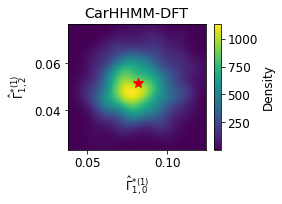

Sample Mean: [0.080815  0.0499264]
Bias: [-0.00090312 -0.00158359]
Empirical Standard Error: 
 [0.0143849  0.00901092]
Fischer Standard Error: 
 [0.01174107 0.00832481]
pm: [0.00139779 0.00097087]
[[2.69643529e-08 2.17623125e-01]
 [2.49214828e-08 2.76992446e-01]
 [2.58148359e-08 2.50893085e-01]
 [2.62756056e-08 2.37804726e-01]
 [2.63115670e-08 2.37062337e-01]
 [2.74137970e-08 2.04584202e-01]
 [2.63484729e-08 2.35593440e-01]
 [2.72091336e-08 2.10522427e-01]
 [2.68277162e-08 2.21687171e-01]
 [2.72654575e-08 2.08902561e-01]
 [2.77896202e-08 1.93496930e-01]
 [2.15466480e-08 3.74893632e-01]
 [2.63979630e-08 2.34124463e-01]
 [2.63359295e-08 2.35981309e-01]
 [2.57703296e-08 2.52428642e-01]
 [2.32542081e-08 3.25279369e-01]
 [2.35792514e-08 3.15932288e-01]
 [2.55356361e-08 2.59011054e-01]
 [2.67668037e-08 2.23457068e-01]
 [2.64931286e-08 2.31450318e-01]
 [2.61237231e-08 2.42395522e-01]
 [2.81452968e-08 1.83511156e-01]
 [2.53432317e-08 2.64751273e-01]
 [2.77615244e-08 1.94625891e-01]
 [2.5632826

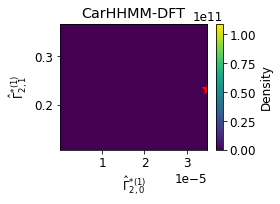

Sample Mean: [2.63127569e-08 2.36616160e-01]
Bias: [-3.48124773e-05  4.02641692e-03]
Empirical Standard Error: 
 [1.49383803e-09 4.33400276e-02]
Fischer Standard Error: 
 [1.14176229e-05 3.56275399e-02]
pm: [       nan 0.00641594]
[[1.15530650e-01 2.42587444e-03]
 [1.23394225e-01 3.85117935e-03]
 [1.08917684e-01 3.14311617e-03]
 [1.19207327e-01 7.30414265e-04]
 [1.61753295e-01 8.57603756e-07]
 [8.59438055e-02 7.13864006e-03]
 [1.14175652e-01 3.90419472e-07]
 [1.09838179e-01 3.22510499e-03]
 [1.15829937e-01 1.02959679e-07]
 [1.17836752e-01 1.08628318e-06]
 [1.33838822e-01 3.44812800e-07]
 [1.24035051e-01 9.70809930e-08]
 [1.04970263e-01 4.77518620e-07]
 [9.80256191e-02 1.02137229e-09]
 [1.10781797e-01 2.46321188e-07]
 [1.28590439e-01 1.63624525e-07]
 [1.48938747e-01 9.40424705e-07]
 [1.03991100e-01 6.59468418e-07]
 [1.14357870e-01 2.61078320e-09]
 [1.34022428e-01 1.82691356e-08]
 [1.17215329e-01 7.27896879e-07]
 [1.13665617e-01 1.12699243e-03]
 [1.08460357e-01 9.34638208e-08]
 [1.287112

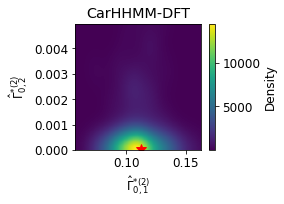

Sample Mean: [0.10989507 0.00053412]
Bias: [-0.00223702  0.00049381]
Empirical Standard Error: 
 [0.01760495 0.00147887]
Fischer Standard Error: 
 [0.01569041 0.00040272]
pm: [0.00340036        nan]
[[0.18847426 0.03453595]
 [0.13032814 0.04167464]
 [0.1640166  0.04783525]
 [0.15526532 0.05853074]
 [0.17936955 0.01591275]
 [0.16845667 0.04165986]
 [0.12283369 0.02829493]
 [0.1858817  0.02430049]
 [0.12484477 0.02469342]
 [0.16452017 0.0471992 ]
 [0.11496126 0.04252136]
 [0.18335828 0.05888921]
 [0.16095553 0.0257716 ]
 [0.13136348 0.0429655 ]
 [0.2037373  0.02332243]
 [0.13364762 0.03947959]
 [0.15870549 0.03385448]
 [0.18120615 0.05234381]
 [0.14221832 0.06033345]
 [0.15216351 0.04363524]
 [0.12197518 0.02434393]
 [0.16187341 0.03756011]
 [0.11483623 0.02575913]
 [0.14306527 0.03874469]
 [0.11830956 0.03906464]
 [0.17135487 0.03515958]
 [0.10584461 0.06717781]
 [0.16211776 0.04072647]
 [0.15635899 0.03017405]
 [0.17752049 0.00508425]
 [0.16317695 0.03149639]
 [0.16346794 0.01833159]
 

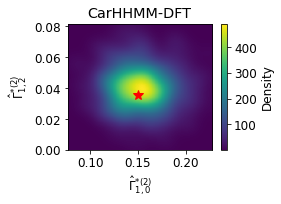

Sample Mean: [0.15169749 0.04065023]
Bias: [0.00148597 0.00509297]
Empirical Standard Error: 
 [0.02519456 0.01366042]
Fischer Standard Error: 
 [0.02215868 0.01156326]
pm: [0.00504998 0.00339197]
[[3.32437738e-08 2.44079341e-01]
 [3.31901086e-08 2.45378717e-01]
 [3.62668628e-08 1.75216425e-01]
 [3.56924107e-08 1.88078767e-01]
 [4.16497406e-08 5.39319940e-02]
 [3.74471539e-08 1.48482377e-01]
 [3.11696335e-08 2.91228053e-01]
 [3.62725123e-08 1.75192766e-01]
 [3.21260979e-08 2.69491629e-01]
 [3.16040453e-08 2.81451060e-01]
 [3.31934311e-08 2.45208552e-01]
 [2.82341780e-08 3.57977906e-01]
 [2.55239337e-08 4.19606643e-01]
 [3.66566942e-08 1.66457794e-01]
 [3.60514473e-08 1.80200913e-01]
 [3.55399614e-08 1.91897698e-01]
 [3.55849638e-08 1.90829764e-01]
 [2.23770271e-08 4.91164723e-01]
 [3.01449301e-08 3.14574709e-01]
 [3.03573660e-08 3.09698350e-01]
 [3.41607300e-08 2.23228498e-01]
 [3.56599883e-08 1.89121060e-01]
 [3.24340293e-08 2.62476351e-01]
 [3.53539826e-08 1.96095312e-01]
 [3.6271910

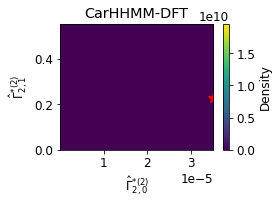

Sample Mean: [3.25596276e-08 2.59623403e-01]
Bias: [-3.50998986e-05  3.35024241e-02]
Empirical Standard Error: 
 [4.30494305e-09 9.78856448e-02]
Fischer Standard Error: 
 [1.94070457e-05 6.05766535e-02]
pm: [nan nan]


In [15]:
# make Gamma

G0_coarse = [0.15,0.91]

G0_fine_1 = HHMM.eta_2_ptm(np.array([[  0.    ,  -1.0873, -10.00 ],
                                     [ -2.3615,   0.    , -2.823 ],
                                     [ -10.000,  -1.1937,  0.    ]]))
G0_fine_2 = HHMM.eta_2_ptm(np.array([[  0.    ,  -2.0691,  -10.000],
                                     [ -1.6902,   0.    ,  -3.1311],
                                     [ -10.000,  -1.2303,   0.    ]]))
if 'hhmm' in model:
    
    # Gamma Coarse
    make_2d_kde_gamma(G0_coarse,hhmms,-1,-1)
    
    # Gamma Fine 1
    make_2d_kde_gamma([],hhmms,0,0)
    make_2d_kde_gamma([G0_fine_1[1,0],G0_fine_1[1,2]],hhmms,0,1)
    make_2d_kde_gamma([G0_fine_1[2,0],G0_fine_1[2,1]],hhmms,0,2)
    
    # Gamma Fine 2
    make_2d_kde_gamma([G0_fine_2[0,1],G0_fine_2[0,2]],hhmms,1,0)
    make_2d_kde_gamma([G0_fine_2[1,0],G0_fine_2[1,2]],hhmms,1,1)
    make_2d_kde_gamma([G0_fine_2[2,0],G0_fine_2[2,1]],hhmms,1,2)
    
else:
    
    G0 = []
    make_2d_kde_gamma(G0,hhmms,0,0)
    make_2d_kde_gamma(G0,hhmms,0,1)
    make_2d_kde_gamma(G0,hhmms,0,2)

# Consider $\hat \Theta$ Coarse

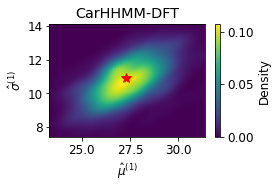

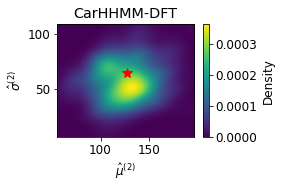

$\hat \mu$ sample mean: [ 27.35353127 125.95121239]
Bias: [ 0.08353127 -1.11878761]
Empirical Standard Error: [ 1.34189083 23.63225169]
Fischer Standard Error: [ 1.02126975 15.28205246]
pm: [0.08535782 5.29482041]

$\sigma$ sample mean: [10.77307767 57.39896243]
Bias: [-0.13692233 -6.66103757]
Empirical Standard Error: [ 1.11494896 17.16525891]
Fischer Standard Error: [ 0.83564103 12.71024555]
pm: [0.08523995 4.57267872]



In [8]:
# dive duration
if 'hhmm' in model:
    theta0 = {'mu':[27.27,127.07],'sig':[10.91,64.06],'corr':[0,0]}
    N = 2
else:
    sig = np.array([np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))])
    theta0 = None
    #theta0 = {'mu':[],'sig':[],'corr':[]}
    N = 1
    
make_2d_kde_theta('dive_duration',theta0,hhmms,-1,N,include_corr=False,feature_name='Y')

# Consider $\hat \theta^*$ Fine

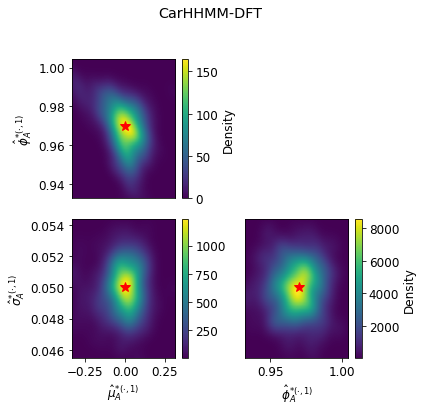

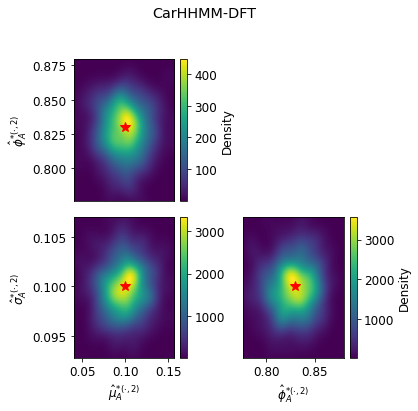

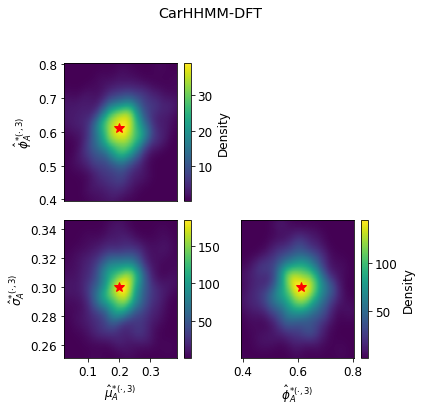

$\hat \mu$ sample mean: [-0.00994673  0.09841331  0.20379406]
Bias: [-0.00994673 -0.00158669  0.00379406]
Empirical Standard Error: [0.10791079 0.01944254 0.05999031]
Fischer Standard Error: [0.06723742 0.01907364 0.05346598]
pm: [0.09590094 0.0021628  0.01104646]

$\sigma$ sample mean: [0.04990713 0.09986937 0.29856039]
Bias: [-9.28719581e-05 -1.30628040e-04 -1.43961430e-03]
Empirical Standard Error: [0.00148606 0.00238209 0.0159115 ]
Fischer Standard Error: [0.00152043 0.00239005 0.01512454]
pm: [0.00018535 0.00014254 0.00153383]

$\rho$ sample mean: [0.96849785 0.82804747 0.59891029]
Bias: [-0.00150215 -0.00195253 -0.01108971]
Empirical Standard Error: [0.01192035 0.01713467 0.0679726 ]
Fischer Standard Error: [0.01013468 0.01664153 0.06468643]
pm: [0.00220154 0.0013496  0.00789326]



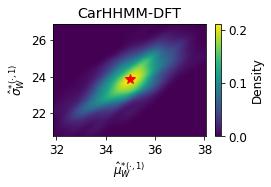

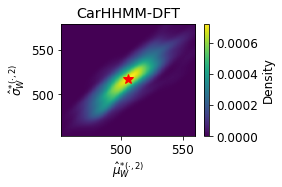

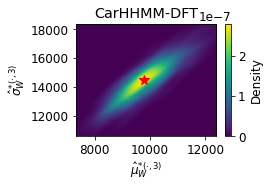

$\hat \mu$ sample mean: [  34.95977837  505.85324298 9857.06477965]
Bias: [-2.02216345e-02  6.32429772e-02  8.70847797e+01]
Empirical Standard Error: [  1.03134839  17.94525978 847.49216171]
Fischer Standard Error: [  0.66027647   9.79678125 370.72760009]
pm: [0.07680761 0.62417618        nan]

$\sigma$ sample mean: [   23.80838102   515.86980912 14485.88201239]
Bias: [-0.04161898 -0.81019088 23.33201239]
Empirical Standard Error: [1.02449151e+00 2.09912128e+01 1.29647924e+03]
Fischer Standard Error: [  0.6520047   11.56408239 428.07935942]
pm: [0.08018585 0.71799609        nan]



In [9]:
# acceleration
N_star = 3
theta0 = {'mu':[0.0,0.1,0.2],'sig':[0.05,0.1,0.3],'corr':[0.97,0.83,0.61]}
dive_type = 0

if 'uncorr' in model:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='A')
else:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=True,feature_name='A')

if 'FV' in model:
    # FoVeDBA
    #F_mus0 = np.array([sum([5.0/n for n in range(2,12)]),
    #                   300 + sum([5.0/n for n in range(4,12)])])
    #F_sigs0 = np.sqrt(F_mus0)
    theta0 = {'mu':[34.98,505.79,9769.98],'sig':[23.85,516.68,14462.55],'corr':[0,0,0]}
    dive_type = 0
    make_2d_kde_theta('FoVeDBA',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='W')

# Get percentage of time in right dive and subdive states

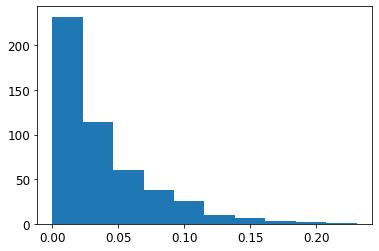

0.03769677783404003
0.03760981473162147


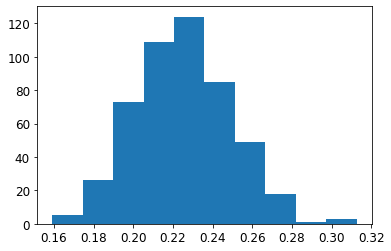

0.2252517595658801
0.02360813480770618


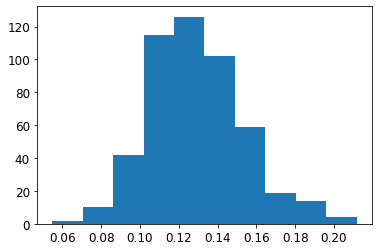

0.1291527068835713
0.02433254946327468


In [10]:
def acc(CM):
    return (CM[0,0]+CM[1,1])/np.sum(CM)

# get coarse accuracy
accuracies_coarse = [1.0-acc(hhmm.CM[0]) for hhmm in hhmms]
plt.hist(accuracies_coarse)
plt.show()
print(np.mean(accuracies_coarse))
print(np.std(accuracies_coarse))

accuracies_fine0 = [1.0-acc(hhmm.CM[1][0]) for hhmm in hhmms]
plt.hist(accuracies_fine0)
plt.show()
print(np.mean(accuracies_fine0))
print(np.std(accuracies_fine0))

accuracies_fine1 = [1.0-acc(hhmm.CM[1][1]) for hhmm in hhmms]
plt.hist(accuracies_fine1)
plt.show()
print(np.mean(accuracies_fine1))
print(np.std(accuracies_fine1))

# Get time to train

In [11]:
hhmm.theta

[{'dive_duration': {'mu': array([ 29.21695192, 119.08822528]),
   'sig': array([11.67955636, 33.79284226]),
   'corr': array([-10., -10.])}},
 [{'FoVeDBA': {'mu': array([  35.35257546,  519.32152936, 9104.37657871]),
    'sig': array([   23.90592708,   522.4068463 , 13923.22224263]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([-0.00257214,  0.11216481,  0.15558032]),
    'sig': array([0.0514866 , 0.10163928, 0.33105465]),
    'corr': array([2.95659461, 1.77571061, 0.48127486])}},
  {'FoVeDBA': {'mu': array([  35.35257546,  519.32152936, 9104.37657871]),
    'sig': array([   23.90592708,   522.4068463 , 13923.22224263]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([-0.00257214,  0.11216481,  0.15558032]),
    'sig': array([0.0514866 , 0.10163928, 0.33105465]),
    'corr': array([2.95659461, 1.77571061, 0.48127486])}}]]

389.84550761889574
118.45852301868722


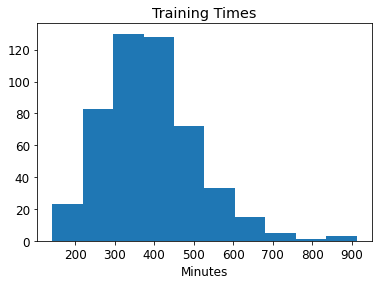

In [12]:
times = [hhmm.train_time/60.0 for hhmm in hhmms]
plt.hist(times)
plt.title('Training Times')
plt.xlabel('Minutes')
print(np.mean(times))
print(np.std(times))

# Make Table for Report

In [13]:
def make_table_dd():
    
    feature = 'dive_duration'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    p_mus = []
    p_sigs = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        #if model == 'hhmm_FV':
        #    hhmms.pop(411) 
                
        # get estimates
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.mean(mus,0))
        try:
            mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])
        except:
            print(hhmms[1].SEs)
            print(feature)

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.mean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        # get biases a p-values
        if model == 'hmm_FV':
            bias_mus.append('NaN')
            bias_sigs.append('NaN')
            p_mus.append('NaN')
            p_sigs.append('NaN')
        else:
            bias_mus.append(est_mus[-1] - dd_mu)
            bias_sigs.append(est_sigs[-1] - dd_sig)
            p_mus.append(ttest_1samp(mus,dd_mu,axis=0,nan_policy='omit')[1])
            p_sigs.append(ttest_1samp(sigs,dd_sig,axis=0,nan_policy='omit')[1])
            
        # get empirical standard errors
        ESE_mus.append(np.std(mus,0))
        ESE_sigs.append(np.std(sigs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[]
\label{table:dive_duration}
\centering
\caption{Estimates and standard errors of parameters for dive duration distribution for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.9}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{4}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & ---                        & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & ---                        & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\ \hline
\multirow{4}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHHMM}    & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
        
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
        
    est_mus[3][0],bias_mus[3][0],p_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_mus[3][1],bias_mus[3][1],p_mus[3][1],ESE_mus[3][1],FSE_mus[3][1],FSE_mus_SE[3][1],
    est_sigs[3][0],bias_sigs[3][0],p_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    est_sigs[3][1],bias_sigs[3][1],p_sigs[3][1],ESE_sigs[3][1],FSE_sigs[3][1],FSE_sigs_SE[3][1],
    )
    return table

print(make_table_dd())

NameError: name 'dd_mu' is not defined

In [ ]:
def make_table_A():
    
    feature = 'A'
    
    est_mus = []
    est_sigs = []
    est_corrs = []
    bias_mus = []
    bias_sigs = []
    bias_corrs = []
    ESE_mus = []
    ESE_sigs = []
    ESE_corrs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    FSE_corrs = []
    FSE_corrs_SE = []
    p_mus = []
    p_sigs = []
    p_corrs = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                    
        #if model == 'hhmm_FV':
        #    hhmms.pop(411) 
            
        # get estimates
        mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.mean(mus,0))
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.mean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        corrs = expit(np.array([hhmm.theta[1][0][feature]['corr'] for hhmm in hhmms]))
        est_corrs.append(np.mean(corrs,0))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
        
        # get biases
        bias_mus.append(est_mus[-1] - acc_mu)
        p_mus.append(ttest_1samp(mus,acc_mu,axis=0,nan_policy='omit')[1])
        bias_sigs.append(est_sigs[-1] - acc_sig)
        p_sigs.append(ttest_1samp(sigs,acc_sig,axis=0,nan_policy='omit')[1])
        if model != 'hhmm_FV_uncorr':
            bias_corrs.append(est_corrs[-1] - np.array(corr_fine))
            p_corrs.append(ttest_1samp(corrs,corr_fine,axis=0,nan_policy='omit')[1])
        else:
            bias_corrs.append([])
            p_corrs.append([])

        # get empirical standard errors
        ESE_mus.append(np.std(mus,0))
        ESE_sigs.append(np.std(sigs,0))
        ESE_corrs.append(np.std(corrs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
        FSE_corrs.append(np.nanmedian(corrs_SE,0))
        FSE_corrs_SE.append(iqr(corrs_SE,0,nan_policy='omit'))
        
    
    table = r'''
\begin{table}[]
\centering
\caption{Estimates and standard errors of parameters for $A^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{6}{*}{CarHMM-DFT} & \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
\multirow{6}{*}{HHMM-DFT}   & \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\ \hline
                            &                               & 3                                & ------                         & ------                     & ------                             & ------                                      \\
\multirow{6}{*}{CarHHMM}    & \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
\multirow{6}{*}{CarHHMM-DFT}& \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],p_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_mus[0][2],bias_mus[0][2],p_mus[0][2],ESE_mus[0][2],FSE_mus[0][2],FSE_mus_SE[0][2],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],p_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    est_sigs[0][2],bias_sigs[0][2],p_sigs[0][2],ESE_sigs[0][2],FSE_sigs[0][2],FSE_sigs_SE[0][2],
    est_corrs[0][0],bias_corrs[0][0],p_corrs[0][0],ESE_corrs[0][0],FSE_corrs[0][0],FSE_corrs_SE[0][0],
    est_corrs[0][1],bias_corrs[0][1],p_corrs[0][1],ESE_corrs[0][1],FSE_corrs[0][1],FSE_corrs_SE[0][1],
    est_corrs[0][2],bias_corrs[0][2],p_corrs[0][2],ESE_corrs[0][2],FSE_corrs[0][2],FSE_corrs_SE[0][2],
        
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_mus[1][2],bias_mus[1][2],p_mus[1][2],ESE_mus[1][2],FSE_mus[1][2],FSE_mus_SE[1][2],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
    est_sigs[1][2],bias_sigs[1][2],p_sigs[1][2],ESE_sigs[1][2],FSE_sigs[1][2],FSE_sigs_SE[1][2],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_mus[2][2],bias_mus[2][2],p_mus[2][2],ESE_mus[2][2],FSE_mus[2][2],FSE_mus_SE[2][2],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
    est_sigs[2][2],bias_sigs[2][2],p_sigs[2][2],ESE_sigs[2][2],FSE_sigs[2][2],FSE_sigs_SE[2][2],    
    est_corrs[2][0],bias_corrs[2][0],p_corrs[2][0],ESE_corrs[2][0],FSE_corrs[2][0],FSE_corrs_SE[2][0],
    est_corrs[2][1],bias_corrs[2][1],p_corrs[2][1],ESE_corrs[2][1],FSE_corrs[2][1],FSE_corrs_SE[2][1],
    est_corrs[2][2],bias_corrs[2][2],p_corrs[2][2],ESE_corrs[2][2],FSE_corrs[2][2],FSE_corrs_SE[2][2],    
    
    est_mus[3][0],bias_mus[3][0],p_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_mus[3][1],bias_mus[3][1],p_mus[3][1],ESE_mus[3][1],FSE_mus[3][1],FSE_mus_SE[3][1],
    est_mus[3][2],bias_mus[3][2],p_mus[3][2],ESE_mus[3][2],FSE_mus[3][2],FSE_mus_SE[3][2],
    est_sigs[3][0],bias_sigs[3][0],p_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    est_sigs[3][1],bias_sigs[3][1],p_sigs[3][1],ESE_sigs[3][1],FSE_sigs[3][1],FSE_sigs_SE[3][1],
    est_sigs[3][2],bias_sigs[3][2],p_sigs[3][2],ESE_sigs[3][2],FSE_sigs[3][2],FSE_sigs_SE[3][2],
    est_corrs[3][0],bias_corrs[3][0],p_corrs[3][0],ESE_corrs[3][0],FSE_corrs[3][0],FSE_corrs_SE[3][0],
    est_corrs[3][1],bias_corrs[3][1],p_corrs[3][1],ESE_corrs[3][1],FSE_corrs[3][1],FSE_corrs_SE[3][1],
    est_corrs[3][2],bias_corrs[3][2],p_corrs[3][2],ESE_corrs[3][2],FSE_corrs[3][2],FSE_corrs_SE[3][2],
    )
    return table

print(make_table_A())

In [ ]:
def make_table_FoVeDBA():
    
    F_mus0 = FoVeDBA_mu 
    F_sigs0 = FoVeDBA_sig
    
    feature = 'FoVeDBA'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    p_mus = []
    p_sigs = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        if model == 'hhmm_FV':
            hhmms.pop(411) 
            
        # get estimates
        if model != 'hhmm_V':
            mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
            est_mus.append(np.mean(mus,0))
            mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

            sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
            est_sigs.append(np.mean(sigs,0))
            sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

            # get biases
            bias_mus.append(est_mus[-1] - F_mus0)
            bias_sigs.append(est_sigs[-1] - F_sigs0)
            
            # get p-values
            p_mus.append(ttest_1samp(mus,F_mus0,axis=0,nan_policy='omit')[1])
            p_sigs.append(ttest_1samp(sigs,F_sigs0,axis=0,nan_policy='omit')[1])
            
            # get empirical standard errors
            ESE_mus.append(np.std(mus,0))
            ESE_sigs.append(np.std(sigs,0))

            # get Fischer Standard Errors
            FSE_mus.append(np.nanmedian(mus_SE,0))
            FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
            FSE_sigs.append(np.nanmedian(sigs_SE,0))
            FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}
\label{table:FoVeDBA}
\centering
\caption{Estimates and standard errors of parameters for $W^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}       \\ \hline
\multirow{4}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHHMM}    & \multirow{2}{*}{$\mu_W^*$}    & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\ \hline
\multirow{4}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],p_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],p_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1]
    )
    return table
print(make_table_FoVeDBA())

In [ ]:
def make_table_Gamma():
    
    est_G0 = []
    est_G10 = []
    est_G11 = []
    bias_G0 = []
    bias_G10 = []
    bias_G11 = []
    ESE_G0 = []
    ESE_G10 = []
    ESE_G11 = []
    FSE_G0 = []
    FSE_G10 = []
    FSE_G11 = []
    FSE_G0_SE = []
    FSE_G10_SE = []
    FSE_G11_SE = []
    p0 = []
    p10 = []
    p11 = []
    
    for model in ['hhmm_FV_uncorr','hmm_FV','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        if model == 'hhmm_FV':
            hhmms.pop(411) 
                
        G0 = []
        SE0 = []
        G10 = []
        SE10 = []
        G11 = []
        SE11 = []
        
        for hhmm in hhmms:
            if model != 'hmm_FV':
                
                # coarse
                ptm = HHMM.eta_2_ptm(hhmm.eta[0])
                SE = hhmm.SEs['Gamma_coarse']
                G0.append(np.array([ptm[0,1],ptm[1,0]]))
                SE0.append(np.array([SE[0,1],SE[1,0]]))
                
                # fine
                ptm = HHMM.eta_2_ptm(hhmm.eta[1][1])
                SE = hhmm.SEs['Gamma_fine'][1]
                G11.append(np.array([ptm[0,1],ptm[1,0]]))
                SE11.append(np.array([SE[0,1],SE[1,0]]))
            
            # fine for both HMM and HHMM
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][0])
            SE = hhmm.SEs['Gamma_fine'][0]
            G10.append(np.array([ptm[0,1],ptm[1,0]]))
            SE10.append(np.array([SE[0,1],SE[1,0]]))
            
            if model == 'hmm_FV':
                G0.append([])
                SE0.append([])
                G11.append([])
                SE11.append([])
            
        # get estimates
        est_G0.append(np.mean(G0,0))
        est_G10.append(np.mean(G10,0))
        est_G11.append(np.mean(G11,0))
        
        # get biases
        if model != 'hmm_FV':
            bias_G0.append(est_G0[-1] - np.array([0.212,0.809]))
            bias_G10.append(est_G10[-1] - np.array([0.32,0.05]))
            bias_G11.append(est_G11[-1] - np.array([0.14,0.15]))
            p0.append(ttest_1samp(G0,[0.212,0.809],axis=0,nan_policy='omit')[1])
            p10.append(ttest_1samp(G10,[0.32,0.05],axis=0,nan_policy='omit')[1])
            p11.append(ttest_1samp(G11,[0.14,0.15],axis=0,nan_policy='omit')[1])
            
            #bias_G0.append(est_G0[-1] - np.array([0.5,0.5]))
            #bias_G10.append(est_G10[-1] - np.array([0.5,0.1]))
            #bias_G11.append(est_G11[-1] - np.array([0.2,0.3]))
            #p0.append(ttest_1samp(G0,[0.5,0.5],axis=0,nan_policy='omit')[1])
            #p10.append(ttest_1samp(G10,[0.5,0.1],axis=0,nan_policy='omit')[1])
            #p11.append(ttest_1samp(G11,[0.2,0.3],axis=0,nan_policy='omit')[1])
        else:
            bias_G0.append([])
            bias_G10.append([])
            bias_G11.append([])
            p0.append([])
            p10.append([])
            p11.append([])

        # get empirical standard errors
        ESE_G0.append(np.std(G0,0))
        ESE_G10.append(np.std(G10,0))
        ESE_G11.append(np.std(G11,0))
        
        # get Fischer Standard Errors
        FSE_G0.append(np.nanmedian(SE0,0))
        FSE_G0_SE.append(iqr(SE0,0,nan_policy='omit'))
        FSE_G10.append(np.nanmedian(SE10,0))
        FSE_G10_SE.append(iqr(SE10,0,nan_policy='omit'))
        FSE_G11.append(np.nanmedian(SE11,0))
        FSE_G11_SE.append(iqr(SE11,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[t]
\centering
\label{table:Gamma}
\caption{Estimates and standard errors of $\Gamma$ and $\Gamma^*$ for all four models. All reported values are averages except for the observed fisher SE, which is a median. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                        & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{14}{*}{HHMM-DFT}   & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
\multirow{14}{*}{CarHMM-DFT} & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
\multirow{14}{*}{CarHHMM}    & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
\multirow{14}{*}{CarHHMM-DFT}& $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
\end{tabular}
}
\end{table}
    ''' % (
    est_G0[0][0],bias_G0[0][0],p0[0][0],ESE_G0[0][0],FSE_G0[0][0],FSE_G0_SE[0][0],
    est_G0[0][1],bias_G0[0][1],p0[0][1],ESE_G0[0][1],FSE_G0[0][1],FSE_G0_SE[0][1],
    est_G10[0][0],bias_G10[0][0],p10[0][0],ESE_G10[0][0],FSE_G10[0][0],FSE_G10_SE[0][0],
    est_G10[0][1],bias_G10[0][1],p10[0][1],ESE_G10[0][1],FSE_G10[0][1],FSE_G10_SE[0][1],
    est_G11[0][0],bias_G11[0][0],p11[0][0],ESE_G11[0][0],FSE_G11[0][0],FSE_G11_SE[0][0],
    est_G11[0][1],bias_G11[0][1],p11[0][1],ESE_G11[0][1],FSE_G11[0][1],FSE_G11_SE[0][1],
        
    est_G10[1][0],ESE_G10[1][0],FSE_G10[1][0],FSE_G10_SE[1][0],
    est_G10[1][1],ESE_G10[1][1],FSE_G10[1][1],FSE_G10_SE[1][1],
    
    est_G0[2][0],bias_G0[2][0],p0[2][0],ESE_G0[2][0],FSE_G0[2][0],FSE_G0_SE[2][0],
    est_G0[2][1],bias_G0[2][1],p0[2][1],ESE_G0[2][1],FSE_G0[2][1],FSE_G0_SE[2][1],
    est_G10[2][0],bias_G10[2][0],p10[2][0],ESE_G10[2][0],FSE_G10[2][0],FSE_G10_SE[2][0],
    est_G10[2][1],bias_G10[2][1],p10[2][1],ESE_G10[2][1],FSE_G10[2][1],FSE_G10_SE[2][1],
    est_G11[2][0],bias_G11[2][0],p11[2][0],ESE_G11[2][0],FSE_G11[2][0],FSE_G11_SE[2][0],
    est_G11[2][1],bias_G11[2][1],p11[2][1],ESE_G11[2][1],FSE_G11[2][1],FSE_G11_SE[2][1],
        
    est_G0[3][0],bias_G0[3][0],p0[3][0],ESE_G0[3][0],FSE_G0[3][0],FSE_G0_SE[3][0],
    est_G0[3][1],bias_G0[3][1],p0[3][1],ESE_G0[3][1],FSE_G0[3][1],FSE_G0_SE[3][1],
    est_G10[3][0],bias_G10[3][0],p10[3][0],ESE_G10[3][0],FSE_G10[3][0],FSE_G10_SE[3][0],
    est_G10[3][1],bias_G10[3][1],p10[3][1],ESE_G10[3][1],FSE_G10[3][1],FSE_G10_SE[3][1],
    est_G11[3][0],bias_G11[3][0],p11[3][0],ESE_G11[3][0],FSE_G11[3][0],FSE_G11_SE[3][0],
    est_G11[3][1],bias_G11[3][1],p11[3][1],ESE_G11[3][1],FSE_G11[3][1],FSE_G11_SE[3][1],
    )
    return table

print(make_table_Gamma())

In [ ]:
def make_table_dive_acc():
    
    # coarse
    est_acc0 = []
    est_acc00 = []
    est_acc01 = []
    std_acc0 = []
    std_acc00 = []
    std_acc01 = []
    
    # fine
    est_acc1 = []
    est_acc100 = []
    est_acc101 = []
    est_acc110 = []
    est_acc111 = []
    
    std_acc1 = []
    std_acc100 = []
    std_acc101 = []
    std_acc110 = []
    std_acc111 = []
    
    # times
    mean_times = []
    std_times = []

    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
            
        if model == 'hhmm_FV':
            hhmms.pop(411)
            
        # Coarse
        acc0   = [(hhmm.CM[0][0,0]+hhmm.CM[0][1,1])/np.sum(hhmm.CM[0]) for hhmm in hhmms]
        acc00 = [hhmm.CM[0][0,0]/(hhmm.CM[0][0,0]+hhmm.CM[0][0,1]) for hhmm in hhmms]
        acc01 = [hhmm.CM[0][1,1]/(hhmm.CM[0][1,0]+hhmm.CM[0][1,1]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc00.append(np.mean(acc00,0))
        est_acc01.append(np.mean(acc01,0))
        est_acc0.append(np.mean(acc0,0))

        # get empirical standard errors
        std_acc00.append(np.std(acc00,0))
        std_acc01.append(np.std(acc01,0))
        std_acc0.append(np.std(acc0,0))
        
        
        # Fine
        acc1   = [(hhmm.CM[1][0][0,0]+hhmm.CM[1][0][1,1]+hhmm.CM[1][1][0,0]+hhmm.CM[1][1][1,1]) \
                 /np.sum(hhmm.CM[1][0] + hhmm.CM[1][1]) for hhmm in hhmms]
        acc100 = [hhmm.CM[1][0][0,0]/(hhmm.CM[1][0][0,0]+hhmm.CM[1][0][0,1]) for hhmm in hhmms]
        acc101 = [hhmm.CM[1][0][1,1]/(hhmm.CM[1][0][1,0]+hhmm.CM[1][0][1,1]) for hhmm in hhmms]
        acc110 = [hhmm.CM[1][1][0,0]/(hhmm.CM[1][1][0,0]+hhmm.CM[1][1][0,1]) for hhmm in hhmms]
        acc111 = [hhmm.CM[1][1][1,1]/(hhmm.CM[1][1][1,0]+hhmm.CM[1][1][1,1]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc100.append(np.mean(acc100,0))
        est_acc101.append(np.mean(acc101,0))
        est_acc110.append(np.mean(acc110,0))
        est_acc111.append(np.mean(acc111,0))
        est_acc1.append(np.mean(acc1,0))

        # get empirical standard errors
        std_acc100.append(np.std(acc100,0))
        std_acc101.append(np.std(acc101,0))
        std_acc110.append(np.std(acc110,0))
        std_acc111.append(np.std(acc111,0))
        std_acc1.append(np.std(acc1,0))
        
        # times
        mean_times.append(np.mean([hhmm.train_time/60.0 for hhmm in hhmms],0))
        std_times.append(np.std([hhmm.train_time/60.0 for hhmm in hhmms],0))
    
    table = r'''
\begin{table}[]
\label{table:accuracy}
\centering
\caption{Accuracies and run times for all models. All reported values are averages, and $\pm$ refers to the standard deviation.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Train Time (m)} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Dive Accuracy} & \multicolumn{1}{c}{Subdive Accuracy}  \\ \hline
\multirow{7}{*}{CarHMM-DFT} & \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & -------------                     & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{3}{*}{-------------}    & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\                            
                            &                                    & 1                             & 3                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{3}{*}{-------------}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline 
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\multirow{7}{*}{HHMM-DFT}   & \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
                            &                                    & 2                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\multirow{7}{*}{CarHHMM}    & \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
                            &                                    & 2                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\multirow{7}{*}{CarHHMM-DFT}& \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 3                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\end{tabular}
}
\end{table}
    ''' % (
        
        mean_times[0],std_times[0],
        #est_acc0[0],std_acc0[0],
        est_acc1[0],std_acc1[0],
        #est_acc00[0],std_acc00[0],
        est_acc100[0],std_acc100[0],
        est_acc101[0],std_acc101[0],
        #est_acc01[0],std_acc01[0],
        est_acc110[0],std_acc110[0],
        est_acc111[0],std_acc111[0],
        
        mean_times[1],std_times[1],
        est_acc0[1],std_acc0[1],
        est_acc1[1],std_acc1[1],
        est_acc00[1],std_acc00[1],
        est_acc100[1],std_acc100[1],
        est_acc101[1],std_acc101[1],
        est_acc01[1],std_acc01[1],
        est_acc110[1],std_acc110[1],
        est_acc111[1],std_acc111[1],
        
        mean_times[2],std_times[2],
        est_acc0[2],std_acc0[2],
        est_acc1[2],std_acc1[2],
        est_acc00[2],std_acc00[2],
        est_acc100[2],std_acc100[2],
        est_acc101[2],std_acc101[2],
        est_acc01[2],std_acc01[2],
        est_acc110[2],std_acc110[2],
        est_acc111[2],std_acc111[2],
        
        mean_times[3],std_times[3],
        est_acc0[3],std_acc0[3],
        est_acc1[3],std_acc1[3],
        est_acc00[3],std_acc00[3],
        est_acc100[3],std_acc100[3],
        est_acc101[3],std_acc101[3],
        est_acc01[3],std_acc01[3],
        est_acc110[3],std_acc110[3],
        est_acc111[3],std_acc111[3])
        
    return table
print(make_table_dive_acc())